# Extracting electrical features and plotting traces using BluePyEfe

This notebook will show you how to use BluePyEfe to extract electrical features from experimental voltage traces. For this example we will use the rat somatosensory cortex data available at: http://microcircuits.epfl.ch/#/article/article_4_eph

Author of this script: Tanguy Damart @ Blue Brain Project

In [1]:
import pathlib
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

import bluepyefe
import bluepyefe.extract

## Using BluePyEfe to extract data and plot traces for a single cell

The low level class in BluePyEfe is called "Cell". It is instanciated as follow:

In [2]:
from bluepyefe.cell import Cell

cell = Cell(name="MouseNeuron")

The recording_reader argument is used to pass a reader function that should match the format of the files. Here we will trust the automatic detection of the format that uses the extension of the file.

Right now, the cell is empty. But it will become a recipient for the recording's data. For that let's use one of the data file present in the tests/exp_data directory. To read a data file, our cell also needs the metadata associated in the form of a dictionnary:

In [3]:
files_metadata = {
    "i_file": "../tests/exp_data/B95_Ch0_IDRest_107.ibw",
    "v_file": "../tests/exp_data/B95_Ch3_IDRest_107.ibw",
    "i_unit": "pA",
    "v_unit": "mV",
    "t_unit": "s",
    "dt": 0.00025,
    "ljp": 14.
}

The exact fields of this dictionary depend of the metadata already present in your file. Check the reader functions present in bluepyefe/reader.py to see which entries are needed.

The units should be the ones in which the recording file is, not the units you want the output to be in. The output units will always be ms, nA, mV.

Using this metadata the cell is able to read the data file. The data is now accessible through the "recordings" attribute. "recordings" is a list that contains as many element as recordings present in the data file:

In [4]:
cell.read_recordings(
    protocol_data=[files_metadata], 
    protocol_name="IDRest"
)

pprint(vars(cell.recordings[0]))

{'amp': 0.037498171441257,
 'amp_rel': None,
 'auto_threshold': -51.27845764160156,
 'config_data': {'dt': 0.00025,
                 'i_file': '../tests/exp_data/B95_Ch0_IDRest_107.ibw',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 'protocol_name': 'IDRest',
                 't_unit': 's',
                 'v_file': '../tests/exp_data/B95_Ch3_IDRest_107.ibw',
                 'v_unit': 'mV'},
 'current': array([-0.02812363, -0.03437332, -0.03124848, ..., -0.03749817,
       -0.02812363, -0.02812363], dtype=float32),
 'dt': 0.25,
 'efeatures': {},
 'export_attr': ['ton',
                 'toff',
                 'tend',
                 'amp',
                 'hypamp',
                 'dt',
                 'amp_rel',
                 'hypamp_rel'],
 'files': ['../tests/exp_data/B95_Ch0_IDRest_107.ibw',
           '../tests/exp_data/B95_Ch3_IDRest_107.ibw'],
 'hypamp': -0.03124847635626793,
 'hypamp_rel': None,
 'id': None,
 'location': None,
 'peak_

Let's select the first trace and plot it:

(<AxesSubplot:title={'center':'Amp = 0.037 nA'}, ylabel='Current (nA)'>,
 <AxesSubplot:xlabel='Time (ms)', ylabel='Voltage (mV)'>)

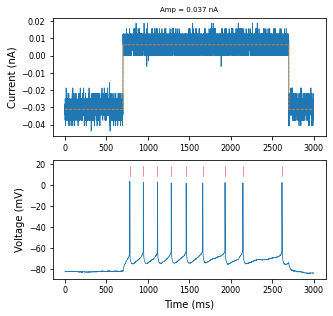

In [5]:
recording = cell.recordings[0]
recording.plot()

Since we did not specify a starting time, finishing time, step amplitude and holding current in the metadata, we implicitly ask BluePyEfe to infer them from the current time series.
BluePyEfe does so throught two steps:
- It tries to guess the shape of the current stimulus based on the name of the protocol. In the present case, IDRest is associated to the eCode "Step" which represent a simple current step.
- It tried to find the beginning and end of the step 
To check if the eCode was interpreted correctly, we can compare above, the original current array (in blue) with an artificial one generated from the ecode_params (in orange).

If you are unhappy with the results (for example the orange line does match with the actual current), you can set the eCode parameters by hand through the metadata. For a step current, the parameters are :'ton', 'toff', 'tend', 'dt', 'amp', and 'hypamp'. For example, if we want to specify the ton and toff by hand, we would do:

    files_metadata = {
        "i_file": "../tests/exp_data/B95_Ch0_IDRest_107.ibw",
        "v_file": "../tests/exp_data/B95_Ch3_IDRest_107.ibw",
        "i_unit": "pA",
        "v_unit": "mV",
        "t_unit": "s",
        "dt": 0.00025,
        "ljp": 14.,
        "ton": 700., 
        "toff": 2700.
    }


Now that we have a voltage time series, we can get efeatures from it. A list of all the features available can be found in the documentation of the eFEL package (https://efel.readthedocs.io/en/latest/eFeatures.html and https://bluebrain.github.io/eFEL/efeature-documentation.pdf). For now, let's make a list with a few features and extract them from all the recordings labelled as "IDRest" protocols:

In [6]:
interesting_efeatures = [
    'Spikecount',
    'mean_frequency',
    'ISI_CV',
    'AP1_amp',
    'AP_width'
]

cell.extract_efeatures(
    protocol_name='IDRest', 
    efeatures=interesting_efeatures
)

pprint(cell.recordings[0].efeatures)

Threshold was not provided and was automatically set to -51.27845764160156


{'AP1_amp': 66.47175655411542,
 'AP_width': 3.111111111108989,
 'ISI_CV': 0.4542672780653756,
 'Spikecount': 9.0,
 'mean_frequency': 4.689820484096835}


## Using BluePyEfe as a bulk efeatures extraction tool

We saw how to read recordings and extract features for a single cell, however the true use of BluePyEfe is to do so for groups of cells.

The first thing we will need to do so is to create a dictionary containing the metadata for all the files we want to use. For the current example on two cells, the structure of this dictionary will be as follows:

In [7]:
import glob

files_metadata = {"B6": {"IDRest": []}, "B8": {"IDRest": []}}

for cell in ["B6", "B8"]:
    for file in glob.glob(f"../tests/exp_data/{cell}/{cell}_Ch0_IDRest_*.ibw"):

        files_metadata[cell]["IDRest"].append({
            "i_file": file,
            "v_file": file.replace("Ch0", "Ch3"),
            "i_unit": "pA",
            "v_unit": "mV",
            "t_unit": "s",
            "dt": 0.00025,
            "ljp": 14.
        })
        
files_metadata

{'B6': {'IDRest': [{'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_181.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_181.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_183.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_183.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_182.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_182.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_185.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_185.ibw',
    'i_unit': 'pA',
    'v_unit': 'mV',
    't_unit': 's',
    'dt': 0.00025,
    'ljp': 14.0},
   {'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_184.ibw',
    'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_184.ibw',


We can now read these recordings. The result of this step is a list of Cells that contains the recordings:

In [8]:
cells = bluepyefe.extract.read_recordings(files_metadata=files_metadata)

pprint(vars(cells[0].recordings[0]))

{'amp': 0.1156193595379591,
 'amp_rel': None,
 'auto_threshold': -46.80992126464844,
 'config_data': {'dt': 0.00025,
                 'i_file': '../tests/exp_data/B6/B6_Ch0_IDRest_181.ibw',
                 'i_unit': 'pA',
                 'ljp': 14.0,
                 'protocol_name': 'IDRest',
                 't_unit': 's',
                 'v_file': '../tests/exp_data/B6/B6_Ch3_IDRest_181.ibw',
                 'v_unit': 'mV'},
 'current': array([-0.00312485, -0.01562424, -0.00937454, ..., -0.00937454,
       -0.01562424, -0.00937454], dtype=float32),
 'dt': 0.25,
 'efeatures': {},
 'export_attr': ['ton',
                 'toff',
                 'tend',
                 'amp',
                 'hypamp',
                 'dt',
                 'amp_rel',
                 'hypamp_rel'],
 'files': ['../tests/exp_data/B6/B6_Ch0_IDRest_181.ibw',
           '../tests/exp_data/B6/B6_Ch3_IDRest_181.ibw'],
 'hypamp': -0.012499390169978142,
 'hypamp_rel': None,
 'id': None,
 'location': Non

The main purpose of BluePyEFe is to output efeatures and protocols that can then be used as input by BluePyOpt. To do so, the efeatures need to be averaged over the cells present in the dataset for different step current amplitude referred to as "targets". These targets need to be defined as percentages of the spiking threshold of the cells, here 150%, 200% and 250%.

Therefore, the second requirement to be able to extract efeatures is a dictionary containing theses targets. They are defined as a combination of a protocol name, target amplitude and names of the efeatures:

In [9]:
interesting_amplitudes = [150, 200, 250]

targets = []
for efeature in interesting_efeatures:
    for amplitude in interesting_amplitudes:

        target = {
            "efeature": efeature,
            "protocol": "IDRest",
            "amplitude": amplitude,
            "tolerance": 20.,
        }

        targets.append(target)

We can now extract the efeatures for these targets:

In [10]:
cells = bluepyefe.extract.extract_efeatures_at_targets(
        cells=cells,
        targets=targets
)

for cell in cells:
    print("\nCell " + cell.name, ": ")
    pprint(cell.recordings[0].efeatures)

Threshold was not provided and was automatically set to -46.80992126464844
Threshold was not provided and was automatically set to -40.21649169921875
Threshold was not provided and was automatically set to -42.65387725830078
Threshold was not provided and was automatically set to -36.37293243408203
Threshold was not provided and was automatically set to -38.12284469604492
Threshold was not provided and was automatically set to -39.34153366088867
Threshold was not provided and was automatically set to -36.87290573120117
Threshold was not provided and was automatically set to -43.560081481933594
Threshold was not provided and was automatically set to -45.778724670410156
Threshold was not provided and was automatically set to -47.278656005859375



Cell B6 : 
{'AP1_amp': 59.778331750135465,
 'AP_width': 2.3384615384597045,
 'ISI_CV': 0.2524553695652191,
 'Spikecount': 26.0,
 'mean_frequency': 9.863429438548126}

Cell B8 : 
{'AP1_amp': 69.2091239924128,
 'AP_width': 2.7999999999979535,
 'ISI_CV': 0.08762231450204114,
 'Spikecount': 75.0,
 'mean_frequency': 37.88357115800014}


We can plot all the recording for the cell:

/Users/damart/Desktop/BluePyEfe/bluepyefe/cell.py:266: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


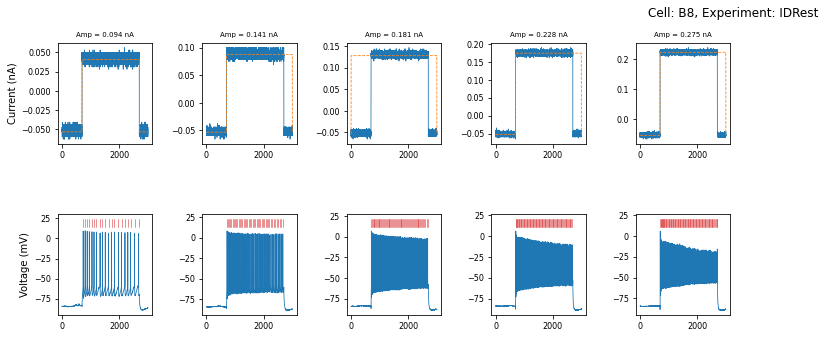

In [11]:
cell.plot_all_recordings(show=True)

The average efeatures for the dataset are a function of the relative amplitude of the step currents with respect to be the rheobase. To be able to compute these relative amplitudes for each cell, we would need for example "IDThresh" data which are often used to find the minimum step current that can induce a spike. In the case where you have data to compute the rheobase (for example IDThresh traces), you will have to pass the list of the protocol names you want to use for this task in protocols_rheobase, e.g:

analyse_threshold(protocols_rheobase  = ["IDThresh", "IV"]).

Since we do not have this data in this example, we are going to set the threshold current by hand for our cells and then ask BluePyEfe to compute the relative amplitude for all the traces:

In [12]:
for cell in cells:
    cell.rheobase = 0.07
    cell.compute_relative_amp()

We can now compute the mean efeatures for our dataset and output the efeatures and protocols files which will also be saved in the MouseCells directory:

In [13]:
protocols = bluepyefe.extract.group_efeatures(cells, targets)

efeatures, protocol_definitions, currents = bluepyefe.extract.create_feature_protocol_files(
    cells=cells,
    protocols=protocols,
    output_directory='MouseCells'
)

pprint(efeatures)
pprint(protocol_definitions)
pprint(currents)

Standard deviation for efeatures Spikecount stimulus IDRest is 0 andwill be set to 0.001
Standard deviation for efeatures mean_frequency stimulus IDRest is 0 andwill be set to 0.001
Standard deviation for efeatures ISI_CV stimulus IDRest is 0 andwill be set to 0.001
Standard deviation for efeatures AP1_amp stimulus IDRest is 0 andwill be set to 0.001
Standard deviation for efeatures AP_width stimulus IDRest is 0 andwill be set to 0.001


{'IDRest_150': {'soma': [{'efeature_name': 'Spikecount',
                          'efel_settings': {},
                          'feature': 'Spikecount',
                          'n': 2,
                          'val': [23.0, 3.0]},
                         {'efeature_name': 'mean_frequency',
                          'efel_settings': {},
                          'feature': 'mean_frequency',
                          'n': 2,
                          'val': [9.991803270827138, 0.12837383227901267]},
                         {'efeature_name': 'ISI_CV',
                          'efel_settings': {},
                          'feature': 'ISI_CV',
                          'n': 2,
                          'val': [0.23593477808268337, 0.016520591482535693]},
                         {'efeature_name': 'AP1_amp',
                          'efel_settings': {},
                          'feature': 'AP1_amp',
                          'n': 2,
                          'val': [64.41873015918

We can also plot the summary efeature plots for the cells which will also be saved as pdfs in the MouseCells directory. On these plots, to know which marker style corresponds to which cells, use the legend.pdf file.

In [20]:
from bluepyefe.plotting import plot_individual_efeatures, plot_grouped_efeatures
output_dir = 'MouseCells'

plot_individual_efeatures(cells, protocols, output_dir, key_amp='amp_rel')
plot_grouped_efeatures(cells, protocols, output_dir, key_amp="amp_rel")

<Figure size 432x288 with 0 Axes>

## Using BluePyEfe to extract efeatures and plot them in one line

The following command performs all the operations detailed above. It is convenient when using BluePyEfe in other workflow or when interacting with the Extractor object is not needed:

Note: this command will not produce any useful result in the present case as we do not have data to compute the rheobase of the cells.

In [21]:
_, _, current = bluepyefe.extract.extract_efeatures(
    output_directory='MouseCells',
    files_metadata=files_metadata,
    targets=targets,
    threshold_nvalue_save=1,
    protocols_rheobase=[],
    write_files=True,
    plot=True,
)

efel_settings is None. Default settings will be used
Cannot compute the relative current amplitude for the recordings of cell B6 because its rheobase is None.
Cannot compute the relative current amplitude for the recordings of cell B8 because its rheobase is None.
/Users/damart/Desktop/BluePyEfe/bluepyefe/extract.py:410: RuntimeWarning: Mean of empty slice
  global_rheobase = numpy.nanmean(
Number of values < threshold_nvalue_save for efeature Spikecount stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature mean_frequency stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature ISI_CV stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature AP1_amp stimulus IDRest_150. The efeature will be ignored
Number of values < threshold_nvalue_save for efeature AP_width stimulus IDRest_150. The efeature will be ignored
No efeatures for stimulus IDRest_150

<Figure size 432x288 with 0 Axes>

In [22]:
assert current["all_holding_current"] == {
    "B6": -0.012499390169978142,
    "B8": -0.05312240868806839,
}
assert current["holding_current"] == [-0.032810899429023266, 0.020311509259045124]
